In [68]:
%matplotlib inline
import pyspeckit
import numpy as np
from astropy import units as u
from astropy.io import fits
from astropy import constants as c
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel
from c_normalize import c_normalize
import glob
import pandas as pd
import warnings
pd.options.display.max_rows = 200
warnings.filterwarnings("ignore")
plt.style.use('seaborn-paper')

In [7]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [14]:
# Select Datasets and extract equivalent widths
spectrum = glob.glob("data/ew_known/tame_inputs/*wavsoln.fits")
by_hand = glob.glob("tame-1.1.0/*.ew")
lc_range = np.arange(0.95,0.995,0.0001)
len_range = 10


d = {'Spectrum File': spectrum, 'By-Hand File': by_hand}
disp_df = pd.DataFrame(data=d)

lines = pd.read_csv(by_hand[0], header=None, delim_whitespace=True)[0].tolist()

In [79]:

width = 10 #Distance from the line on both sides to sample the local continuum from
gauss_amp = -0.2
gauss_width = 0.15
gauss_centhresh = 0.2

pars_dict={'7112.17':(10, -0.3, 0.15, 0.2, 0.2), '5838.37':(10,-0.3,0.15,0.15, 0.15)}

survey = []
all_meas = []
for line in lines:
    # Set fitting parameters
    if line in pars_dict.keys():
        width = pars_dict[line][0] #Distance from the line on both sides to sample the local continuum from
        gauss_amp = pars_dict[line][1]
        gauss_width = pars_dict[line][2]
        gauss_centhresh_l = pars_dict[line][3]
        gauss_centhresh_r = pars_dict[line][4]
    else:
        width = 10 #Distance from the line on both sides to sample the local continuum from
        gauss_amp = -0.2
        gauss_width = 0.15
        gauss_centhresh_l = 0.2
        gauss_centhresh_r = 0.2
    percent_difference = True
    diff = []
    for row in disp_df.iterrows():
        eqw_file, spec_file = row[1]
        eqw_df = pd.read_csv(eqw_file, header=None, delim_whitespace = True)
        if line not in eqw_df[0].tolist():
            print("{} Line Missing: {}".format(spec_file,line))
            continue
        mask = eqw_df[0] == line
        byhand_eqw = eqw_df[4][mask.tolist()].tolist()[0]
        if byhand_eqw == 0.:
            continue
    
        s_hdu = fits.open(spec_file)
    
        # Grab the flux and wavelength arrays from the spectrum
        s_data = s_hdu[1].data
        s_flux = s_data['FLUX']
        #smoothed_flux = convolve(s_flux, Box1DKernel(5)) # Smooth the flux for more reliable continuum fitting
        #s_flux = smoothed_flux
        s_wav = s_data['WAVEL']

        # Specify up a specific line to measure the EQW for, and specify the wavelength range to sample for the local continuum
        lim_l = line - width
        lim_r = line + width

        # Mask the flux and wavelength arrays based on the sampled wavelength range
        wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
        s_flux = s_flux[wav_mask]
        s_wav = s_wav[wav_mask]

        # Normalize the spectrum with the local continuum to 1.0, c_normalize returns the normalized spectrum in norm, but also the local continuum fit in yfit if desired
        yfit, norm, _ = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.99)
        # Load the normalized spectrum into a pyspeckit.Spectrum object
        sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)

        #Get around pyspeckits reliance on a generated baseline and just generate basespec as a ones array (continuum is always one in normalized case)
        sp.baseline.basespec = np.ones(len(s_wav))
        

        #Fit a gaussian to the line, this may be too simplistic for blended lines
        with suppress_stdout(): #Suppress some annoying info messages that don't translate well to automation
            sp.specfit(fittype='gaussian', guesses = [gauss_amp, line, gauss_width], exclude= [0,line-gauss_centhresh_l, line+gauss_centhresh_r, line+5000])
        fwhm = sp.specfit.parinfo[2].value

        #Measure the Equivalent Width of the gaussian line fit against the normalized baseline
        EQW = sp.specfit.EQW(plot=False, continuum_as_baseline=True, xmin = 0, xmax = len(norm))
        EQW = EQW*1000 #mA
        if percent_difference:
            ew_diff = ((EQW-byhand_eqw)/byhand_eqw) * 100 #Percent Difference
        else:
            ew_diff = EQW-byhand_eqw #mA Difference
        if ew_diff < 1000: #Try to cut out some of these crazy fits
            diff.append(ew_diff)
        all_meas.append([line, ew_diff, fwhm])
    if percent_difference:
        symbol = "%"
    else:
        symbol = " mA"
    line_stats = [line, np.median(diff),np.std(diff)]
    survey.append(line_stats)
    #print("{} Statistics".format(line))
    #print("===============")

    #print("Median Difference: {}{}".format(np.median(diff),symbol))
    #print("Standard Deviation of Difference: {}{}".format(np.std(diff), symbol))
    #print("~95% within {}{}".format(np.round(2*np.std(diff), 2), symbol))
    #print(" ")
survey_df = pd.DataFrame(survey, columns=["Line (Angstroms)", "Median Difference","Standard Deviation of Difference"])
all_meas_df = pd.DataFrame(all_meas, columns=["Line (Angstroms)", "Difference","FWHM"])

### Performance Against Known EQWs

In [64]:
print("Difference Type: ",symbol)
survey_df

Difference Type:  %


,Line (Angstroms),Median Difference,Standard Deviation of Difference
0,5307.36,1.382929,2.182357
1,5322.04,2.886897,4.045419
2,5466.99,7.120705,4.459957
3,5491.83,-0.589881,14.937076
4,5522.45,4.577810,7.063699
5,5536.58,19.645158,38.301733
6,5539.28,10.514268,12.027095
7,5560.21,1.725137,4.523798
8,5577.03,9.121010,17.587013
9,5607.66,4.214768,10.577089


Difference Type:  %


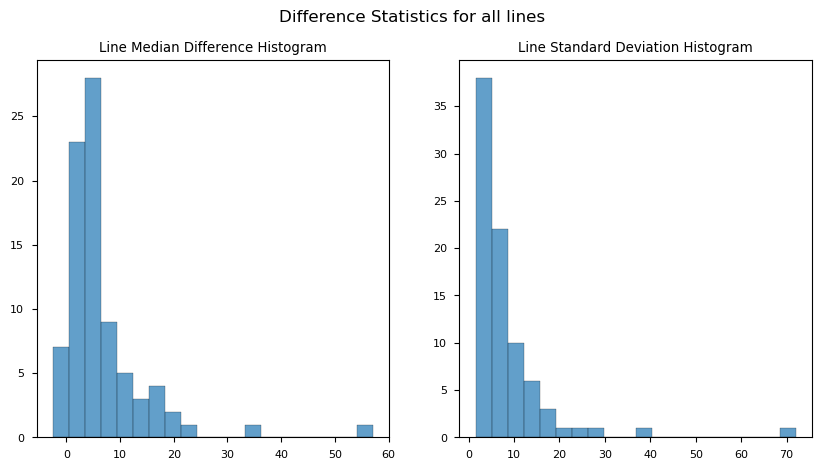

In [65]:
fig, axes = plt.subplots(1,2, figsize = (10,5), dpi = 100)
ax1,ax2 = axes
fig.suptitle("Difference Statistics for all lines")
ax1.hist(survey_df['Median Difference'],histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=20)
ax1.set_title("Line Median Difference Histogram")
ax2.hist(survey_df['Standard Deviation of Difference'], histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=20)
ax2.set_title("Line Standard Deviation Histogram")

print("Difference Type: ",symbol)

Difference Type:  %


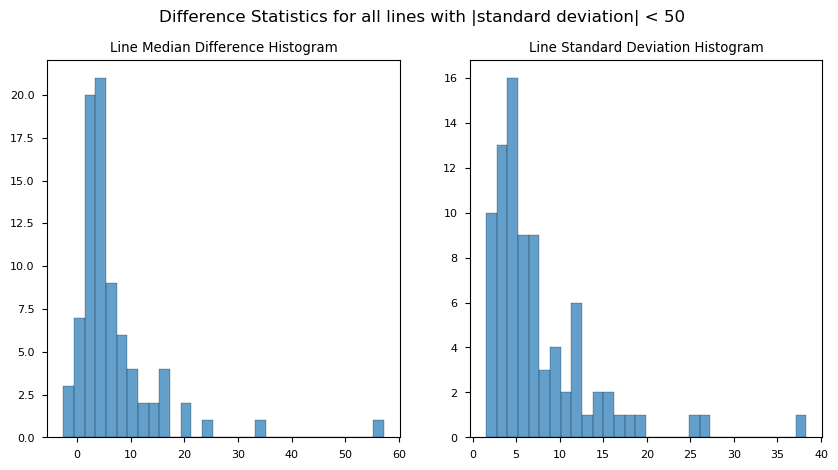

In [66]:
fig, axes = plt.subplots(1,2, figsize = (10,5), dpi = 100)
ax1,ax2 = axes
fig.suptitle("Difference Statistics for all lines with |standard deviation| < 50")
mask = abs(survey_df['Standard Deviation of Difference']) < 50
ax1.hist(survey_df['Median Difference'][mask],histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=30)
ax1.set_title("Line Median Difference Histogram")
ax2.hist(survey_df['Standard Deviation of Difference'][mask], histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=30)
ax2.set_title("Line Standard Deviation Histogram")

print("Difference Type: ",symbol)

### Equivalent Width Agreement compared to Broadening

In [84]:
all_meas_df['FWHM']

0       0.083261
1       0.106180
2       0.085027
3       0.083046
4       0.085262
5       0.084183
6       0.083783
7       0.081359
8       0.083185
9       0.098746
10      0.092920
11      0.086728
12      0.094049
13      0.086110
14      0.089052
15      0.087902
16      0.087280
17      0.088610
18      0.090433
19      0.084762
20      0.087429
21      0.090725
22      0.089328
23      0.091589
24      0.091675
25      0.092807
26      0.090421
27      0.093833
28      0.081021
29      0.083155
30      0.078996
31      0.080361
32      0.082297
33      0.097302
34      0.091661
35      0.092633
36      0.100652
37      0.102076
38      0.105740
39      0.089159
40      0.094849
41      0.098535
42      0.105965
43      0.086397
44      0.075506
45      0.101664
46      0.073167
47      0.074146
48      0.077409
49      0.075033
50      0.074881
51      0.075198
52      0.076814
53      0.090947
54      0.089164
55      0.083792
56      0.092186
57      0.086054
58      0.0909

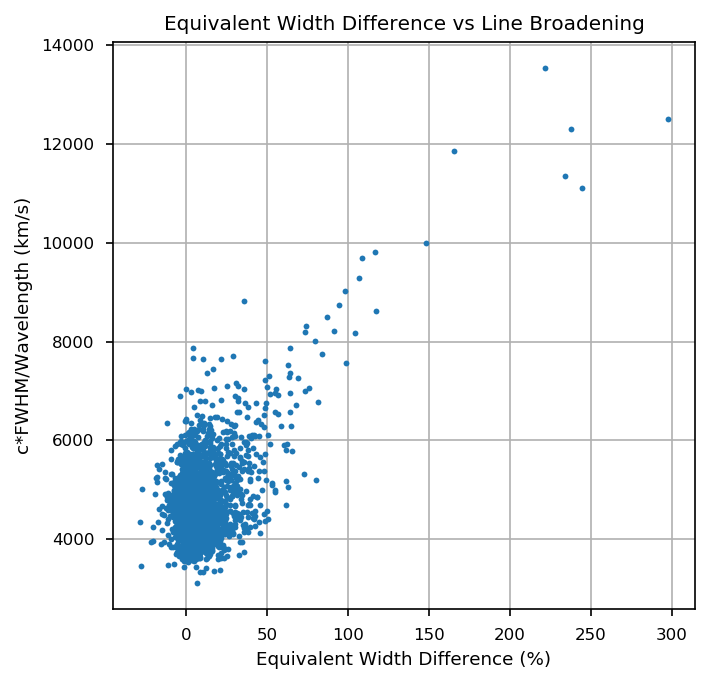

In [103]:
delta_eqw = all_meas_df['Difference']
broadening = c.c.value*(all_meas_df['FWHM']/all_meas_df['Line (Angstroms)'])


fig = plt.figure(figsize=(5,5), dpi=150)
plt.plot(delta_eqw,broadening, '.')
plt.title("Equivalent Width Difference vs Line Broadening")
plt.xlabel("Equivalent Width Difference ({})".format(symbol))
plt.ylabel("c*FWHM/Wavelength (km/s)")
plt.grid()